In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [2]:
def moving_average(a, n=10): 
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret/=n
    # Masking
    ret[:n-1]=ret[n-1]
    ret=ret.reshape(-1,1)
    return ret

def read_train_patients(input_len = 8, output_len = 6):
    x_train=[]
    y_train=[]
    #y_train_f=[]
    for i in range(1, 15):
        #y_noised=[]
        
        df=pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
        dataset=df.values
        dataset = moving_average(dataset)

        scaler = MinMaxScaler(feature_range=(0, 1)) 
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data
        #train_data = dataset
        
        for i in range(input_len,len(train_data)-output_len):
            x_train.append(train_data[i-input_len:i,0])
            y_train.append(train_data[i+output_len-1,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape 
    #x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    return scaler, x_train, y_train


In [3]:
def train_model_KNN(x_train, y_train):
    
    X_val = x_train[11000:]
    Y_val = y_train[11000:]
    X_train = x_train[:11000]
    Y_train = y_train[:11000]

    #KNN model
    knn = KNeighborsRegressor()
    
    # find best hyperparams
    grid_params = {
        'n_neighbors': [i for i in range(1, 61)],
        'weights':['uniform', 'distance'],
        'metric':['euclidean', 'manhattan']
    }
    
    grid_cv = GridSearchCV(knn, grid_params, verbose = 1, cv=3, n_jobs=1)
    gs_results = grid_cv.fit(X_train, Y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    #gs_df = pd.DataFrame(gs_results)
    #gs_df.sort_values(by=['rank_test_score'], inplace=True)
    #gs_df[['params', 'mean_test_score', 'rank_test_score']].head(10)
    
    knn = KNeighborsRegressor(n_neighbors=gs_results.best_params_['n_neighbors'], weights=gs_results.best_params_['weights'], metric = gs_results.best_params_['metric'])
    knn.fit(X_train, Y_train)
    
    #validation
    pred=knn.predict(X_val)
    error = sqrt(mean_squared_error(Y_val,pred))
    print('RMSE:', error)
    
    #plotting the rmse values against k values
    """curve = pd.DataFrame(rmse_val) #elbow curve 
    plt.figure(figsize=(24,16))
    plt.title('RMSE according to the Num of Neighbors(K)',fontsize=40)
    plt.plot(curve, linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel('value of K',fontsize=28)
    plt.ylabel('RMSE',fontsize=28)"""
    
    #validation
    #prediction = knn.predict(X_val)
    #r_squared = knn.score(X_val, Y_val)#?
    #rmse = np.sqrt(mean_squared_error(prediction, Y_val))
    #accuracy = metrics.accuracy_score(Y_val, prediction)
    #print("val_rmse: ", rmse)
    #print("accuracy: ", accuracy)
    return knn



In [4]:
scaler, x_train, y_train = read_train_patients()

In [5]:
knn = train_model_KNN(x_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  2.0min finished


0.8940191131302963
KNeighborsRegressor(metric='euclidean', n_neighbors=7, weights='distance')
{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
RMSE: 0.0619447355038964


In [6]:
def show_plots(i, continuous_ytest, continuous_predictions):
    plt.figure(figsize=(24,16))
    plt.title('Blood Glucose Prediction Model Result_patient_{}'.format(i),fontsize=40)
    plt.plot(continuous_ytest, color = 'b', linewidth=3)
    plt.plot(continuous_predictions, color = 'r', ls="--", linewidth=3)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.ylim(40, 260)
    ax=plt.axes()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.xlabel('Timestamp',fontsize=28)
    plt.ylabel('BG(CGM) (mg/dL)',fontsize=28)
    plt.legend(['Real','Predictions'], loc='upper right',fontsize=32)
    plt.show()

In [7]:
def test_model(model, i, input_len=8, output_len=6):
    df = pd.read_csv("Virtual_patients_20\V_CGMS_{}.csv".format(i),header=None)
    dataset=df.values
    
    dataset = moving_average(dataset)
    
    # Scalling data from 0 - 1 to input in the neural network
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    scaled_data = scaler.fit_transform(dataset)
    
    x_test =[]
    y_test =[]
    
    continuous_ytest=[]
    i= input_len
    
    for i in range(input_len,len(dataset)-output_len):
        x_test.append(scaled_data[i-input_len:i,0])
        y_test.append(dataset[i+output_len-1,0])
        continuous_ytest.append(dataset[i+output_len-1,0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    #y_test = np.reshape(y_test,(-1,1))
    #print("x_test: ", x_test)
    #x_test= np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    predictions = model.predict(x_test)
    predictions = np.reshape(predictions,(1,-1))
    predictions = scaler.inverse_transform(predictions)
    print(predictions)
    print(y_test)
    #print("predictions: ", predictions)
    
    continuous_predictions = predictions[0]
    for i in range(1, len(predictions)):
        continuous_predictions = np.concatenate([continuous_predictions, predictions[i]])
    
    #print(predictions)
    #print(y_test)
    
    
    rmse=np.sqrt(np.mean(((predictions-y_test)**2)))
    mape=np.mean(np.abs((predictions-y_test)/y_test)*100)
    #print("prediction:", np.shape(pred))
    #print("y_test:",np.shape(y_test))
    #print(len(continuous_ytest))
    #print("continuouse_ytest: ", continuous_ytest)
    #print("continuous_predictions: ", continuous_predictions)
    return rmse, mape, continuous_ytest, continuous_predictions

[[104.32398917 104.32398917 104.32398917 102.03516178  98.7446136
   99.19599437 102.29926788 105.72882249 106.52312071 107.673117
  110.35047295 110.8944329  111.72935405 108.60179908 110.58613471
  111.97372273 112.04259512 112.90507029 110.57316587 110.43352761
  113.03428856 110.46325325 109.51469228 108.39593315 104.64035913
  103.88838942 104.57805616 104.59526028 107.71147269 116.45982895
  122.36413341 129.01213822 132.73122415 135.08810507 138.16105049
  141.72834177 143.99900664 142.08841774 137.50295502 135.05475524
  131.94438211 130.93487649 128.57400733 127.84710049 127.34475889
  124.26717217 123.62266925 122.88280313 124.73219176 127.57885396
  128.59160772 125.45301917 117.81310944 117.12651741 114.65149728
  111.98359405 111.28838901 108.33546018 109.0730612  108.99112387
  104.71115255 101.87352089  98.81794899  97.49126541  97.83291567
   98.24823892  99.59398863 101.631626   104.49718978 108.97862303
  115.58885368 116.990844   118.11104428 117.52507096 117.9804124

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


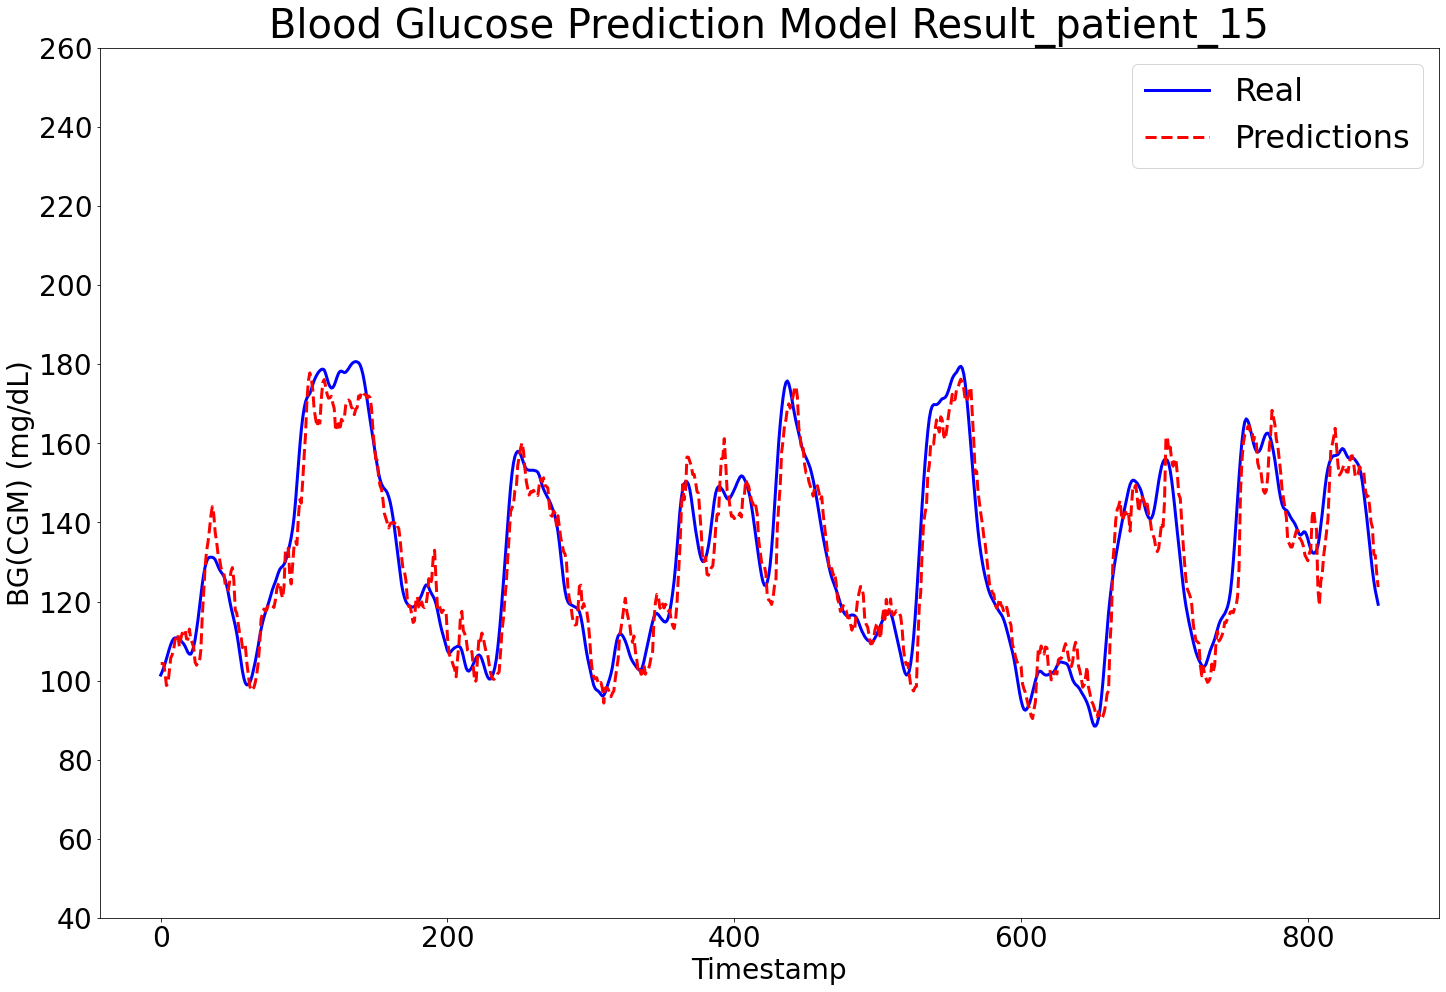

0.9721148013919979
0.9805618524204368
0.982400895563622
Time_delay(min):  15
Root-Mean-Squared Deviation 6.975718710028169
Mean-Absolute-Percentage-Error 4.227314832228304
[[126.33129355 126.33129355 126.33129355 126.15687169 126.17563075
  126.48874745 126.06348066 127.37315717 123.20117368 119.73104262
  114.35253526 105.44154877 105.31727879 104.13508431 102.40333825
  106.06839505 103.69652578 105.59932225 107.9554898  109.62039797
  115.98209368 125.77421957 124.08625545 124.03511011 131.60814764
  134.4673839  135.70987813 138.06210933 134.72805483 129.98596567
  126.67984445 130.1367094  140.35353791 139.56377393 134.36663419
  138.55181478 134.83392993 130.45584325 130.82799613 129.57019303
  127.56865288 123.90309612 121.31709271 120.21114776 122.18934696
  112.1628674  107.2560073  105.73193757 108.63365103 112.38963221
  115.04702013 121.68955759 124.10970588 126.27105744 123.58326859
  127.17169927 125.50658444 128.91272558 126.249357   116.69255073
  118.19207567 121.31700

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


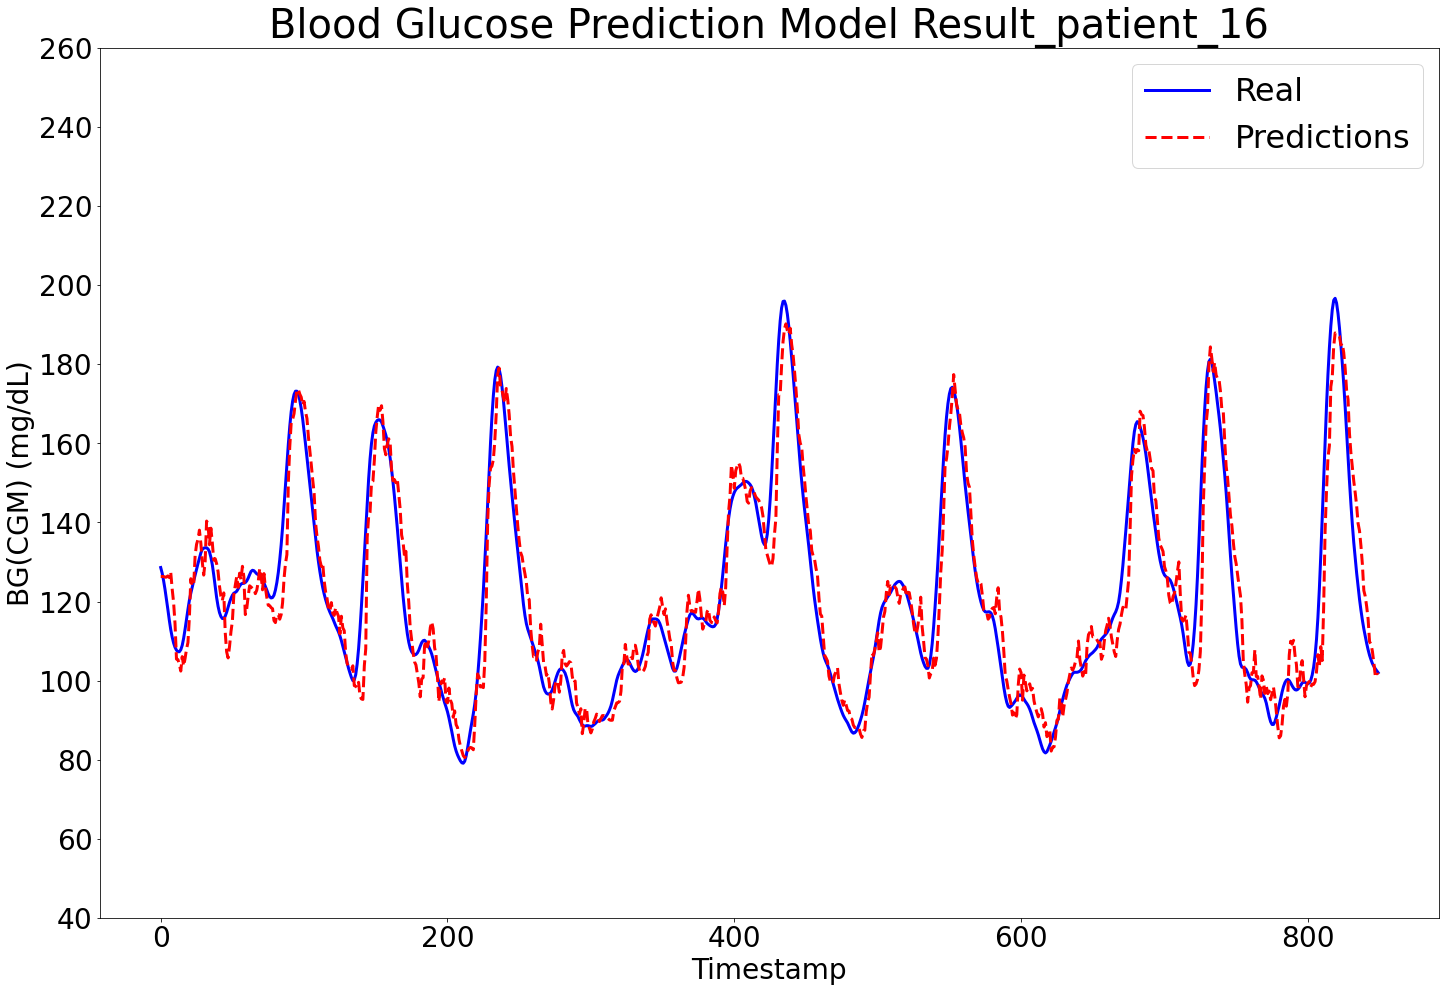

0.9721252777914249
0.9839679026595745
0.9851955079781854
Time_delay(min):  15
Root-Mean-Squared Deviation 8.176996629561947
Mean-Absolute-Percentage-Error 4.816600041310484
[[111.82419524 111.82419524 111.82419524 111.13377663 110.16799878
  112.8132754  110.35689325 108.65686668 107.69167953 106.94872755
  106.4758879  107.1348587  107.09672507 107.42047601 108.62372013
  109.16305687 106.82874682 109.27252045 111.6903288  111.51386821
  111.64429069 113.64298046 111.40997383 110.68198313 110.50150342
  112.36774735 113.3095397  114.51175347 114.62716529 116.2471572
  117.21609981 116.48579523 113.09918368 111.43673663 109.16863241
  106.72956072 106.07995344 104.09406475 104.40258228 104.1062053
  104.94204502 105.04790825 106.90930335 110.97261465 105.28097521
  103.0620738  103.84203536 104.23264015 105.45766734 107.84743126
  107.36796248  99.93480711  97.17811311  97.87334423  98.7140289
  101.91505947 106.60860707 110.62037879 112.83945285 105.46534195
  123.04325018 124.4415752

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


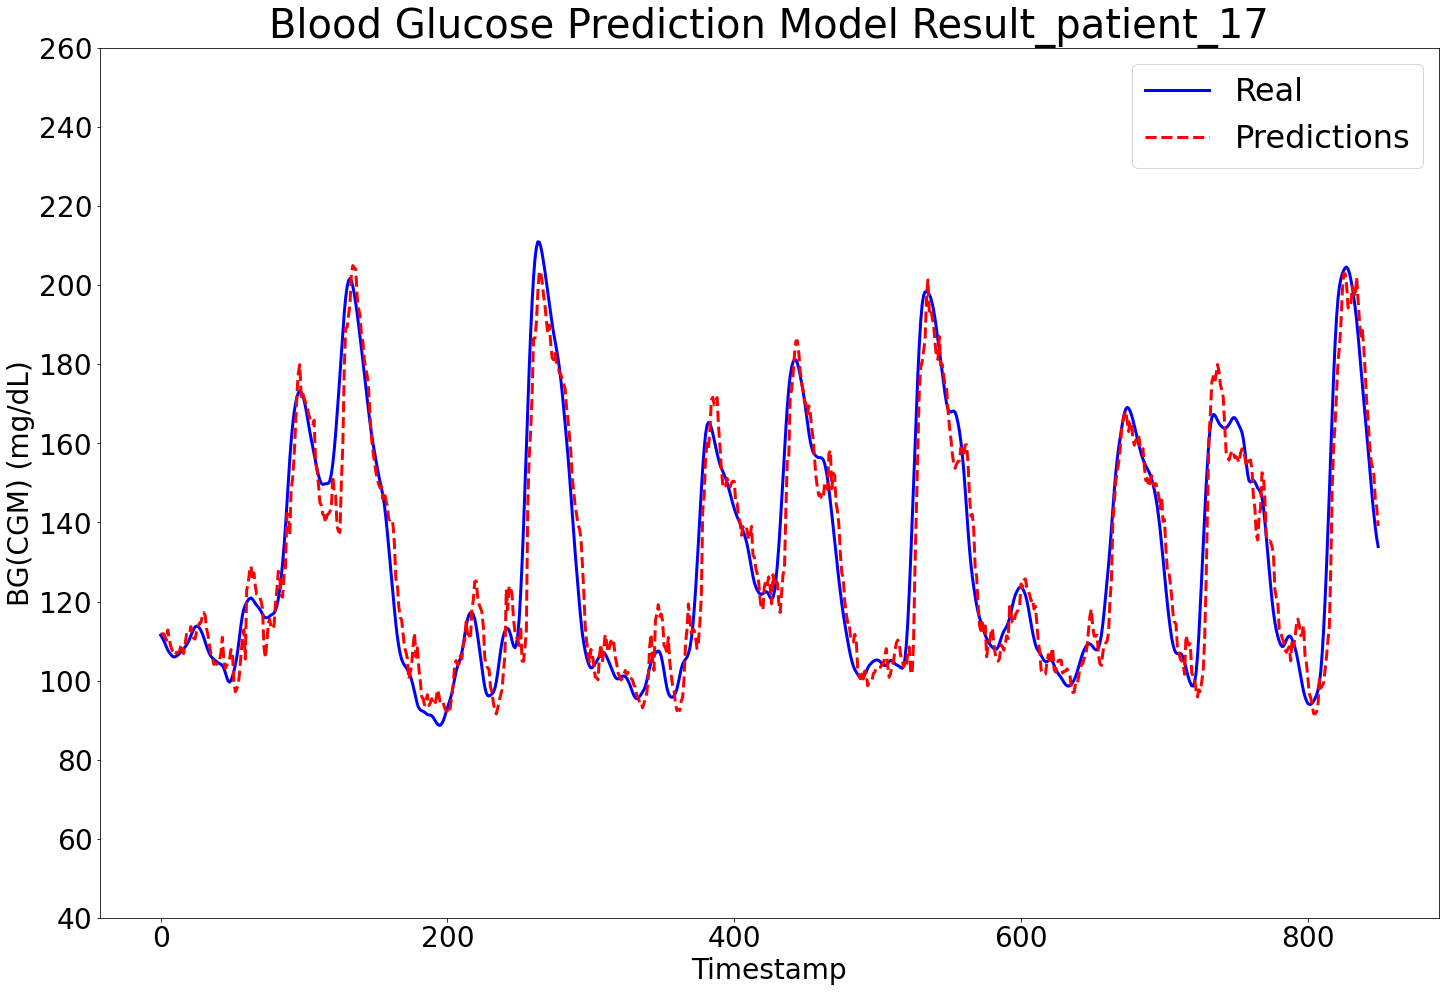

0.9731754477079488
0.9826973098259166
0.984123084139365
Time_delay(min):  15
Root-Mean-Squared Deviation 9.159738371399596
Mean-Absolute-Percentage-Error 4.926604463328398
[[138.73881474 138.73881474 138.73881474 138.73881474 137.33220815
  135.65387836 133.66622362 132.8895369  132.4662905  130.8389584
  130.45754957 128.82613074 129.75166362 129.04883837 128.71932298
  125.35000215 119.45678206 116.11752614 114.72197962 112.6006681
  113.88021474 115.06156873 115.29217728 115.24647316 115.30009758
  120.05831682 131.40378574 141.59802667 139.98903657 130.24510111
  126.19644398 125.90266362 120.7418616  118.47372216 118.81752395
  118.20277608 112.95750424 113.6495663  113.06401155 114.78575658
  120.25792458 120.42871268 118.38847166 115.48765217 107.91182051
  107.32007242 106.90172276 111.8455152  112.75705464 113.1093849
  112.03106456 110.12850046 109.92343548 108.75087622 106.90748211
  107.66161675 108.66391257 108.65782669 112.48633361 113.96919552
  113.88932238 116.36751303

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


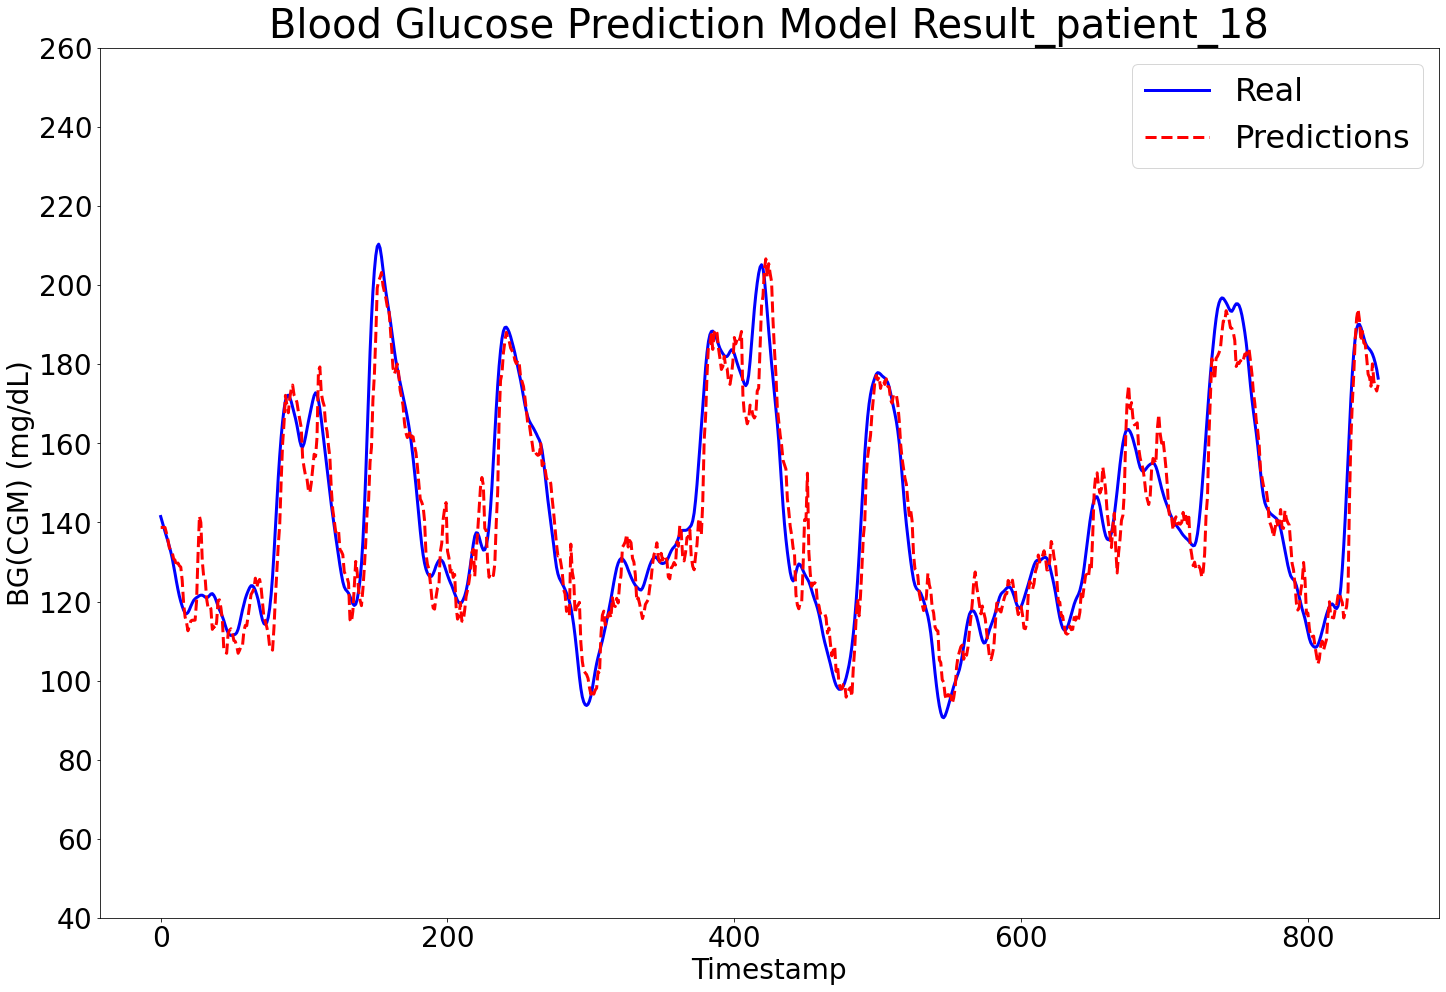

0.967086034565987
0.9772227246703676
0.9795000104326822
Time_delay(min):  15
Root-Mean-Squared Deviation 8.643613413706898
Mean-Absolute-Percentage-Error 4.530863616339663
[[113.06289851 113.06289851 113.06289851 114.94776865 111.39821767
  111.05534757 109.28703935 107.71219222 109.0732887  109.15754756
  109.04257159 103.60474146 102.91036638 102.35153782 101.78517392
  101.84776907 102.14654106 103.53589553 104.13703263 106.01685784
  116.88197137 119.08323616 118.53566082 122.53199825 127.39252981
  123.69108002 115.06231666 110.81272669 108.98041621 107.72668157
  110.36150102 111.31665826 111.61496242 111.82830516 111.78685538
  111.75984412 111.48463839 116.94728298 118.6408625  118.43171721
  116.95251284 121.01956066 126.68100985 130.72166391 140.11262649
  140.25162578 144.15324474 138.91166524 135.04971231 134.08121359
  133.80761598 131.15001902 132.2669119  132.64373798 130.9274538
  130.68661227 131.71753378 132.38463053 133.06235557 132.30339054
  131.30504376 130.073632

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


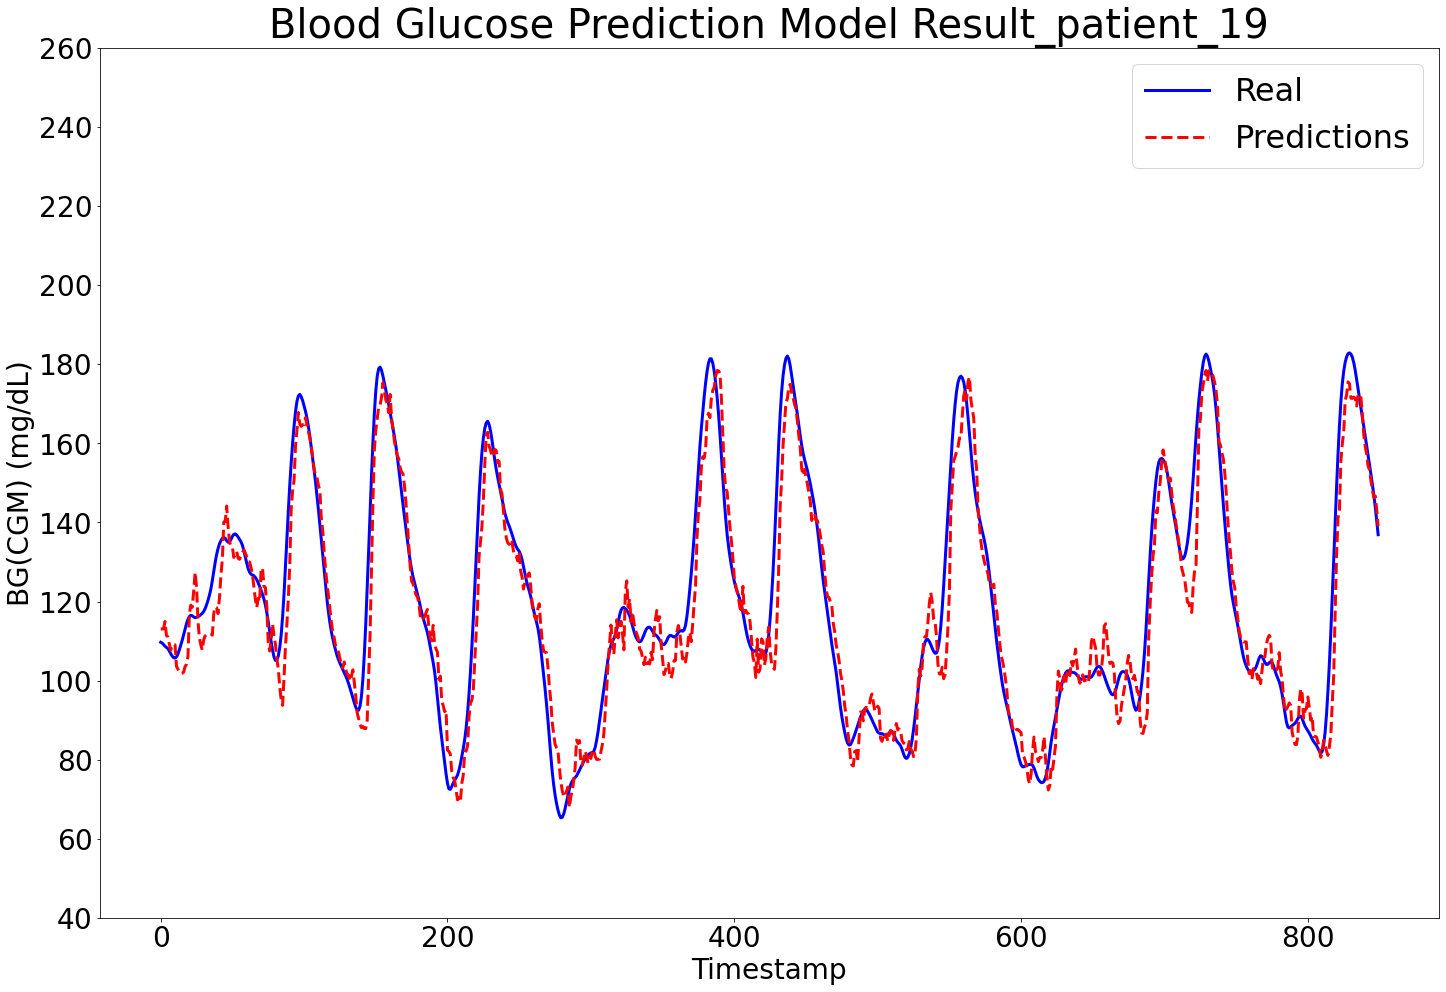

0.9753847066862803
0.9851295385221343
0.9858374206822608
Time_delay(min):  15
Root-Mean-Squared Deviation 8.786926968607721
Mean-Absolute-Percentage-Error 5.400700982146178
[[123.11407695 123.11407695 123.11407695 120.15034299 117.69314915
  117.89238156 119.51045056 121.06763282 122.41812083 124.42155946
  126.85789928 125.51238695 123.87216999 122.40762199 121.85625032
  121.55205359 120.41815071 115.50202866 109.13853711 106.80251027
  101.53554732 103.43092625 102.08234346 100.24185978  98.92418665
   97.79893258  99.32127852  99.68719144 102.50206132 104.88862114
  108.4430857  107.89482384 107.73437754 115.20076023 113.93537116
  115.99604862 112.579097   130.33149149 130.74995179 130.50261462
  126.27571274 128.08379114 129.4653447  128.68997226 123.18682164
  125.93022741 123.7360743  122.18103028 120.72050083 114.66090326
  114.53903872 112.7295267  110.61384975 107.70585806 106.78926408
  101.83683671 100.31675074  99.77385135  99.50594789 101.37634135
  102.77452335 102.2118

<ipython-input-6-4e3172aba1ff>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.axes()


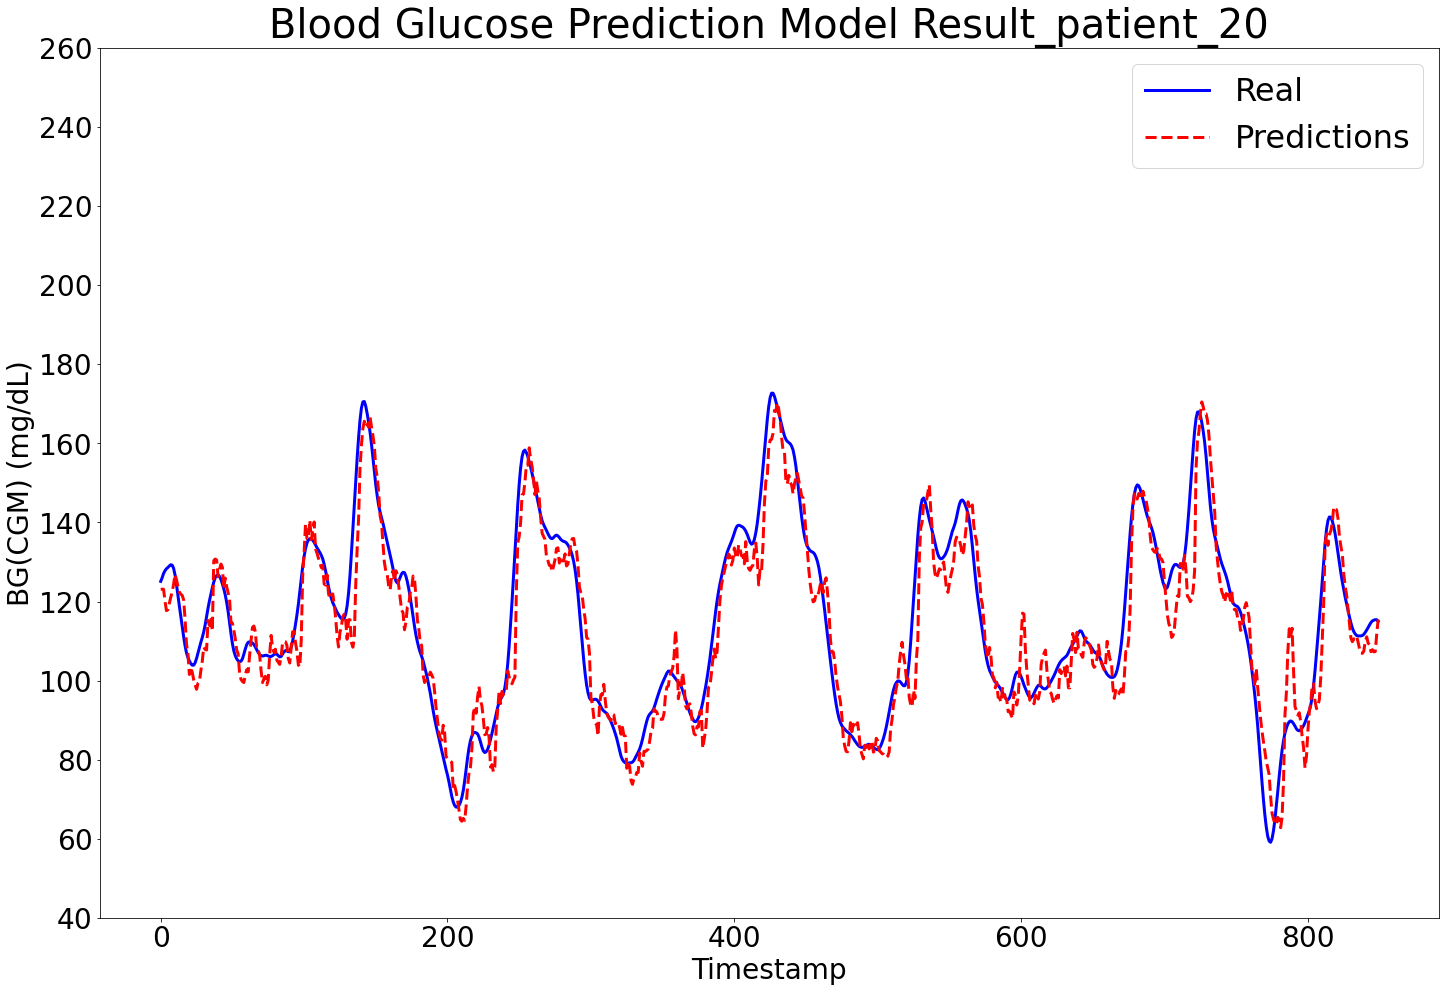

0.9619428202938967
0.9722566509776582
0.9748573403084057
Time_delay(min):  15
Root-Mean-Squared Deviation 8.020345923952938
Mean-Absolute-Percentage-Error 5.284161963331716


In [8]:
def get_time_gain(continuous_ytest, continuous_predictions):
    corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6:-6])[0,1]
    max_corr = corr
    #j=1
    max_trans = 0
    for j in range(1, 6):
        trans_corr = np.corrcoef(continuous_ytest[6:-6], continuous_predictions[6+j:-6+j])[0,1] 
        if max_corr < trans_corr:
            max_corr = trans_corr
            print(max_corr)
            max_trans = j
    return max_trans
    

for i in range(15,21):
    rmse, mape, continuous_ytest, continuous_predictions = test_model(knn, i)
    show_plots(i, continuous_ytest, continuous_predictions)
    time_gain = get_time_gain(continuous_ytest, continuous_predictions)
    print("Time_delay(min): ", time_gain*5)
    print("Root-Mean-Squared Deviation {}".format(rmse))
    print("Mean-Absolute-Percentage-Error {}".format(mape))